# **🔎 Emotion Detection Using CNN**

## **`Author:`** **Muhammad Hasnain**

## **About Dataset**
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

### **Importing Libraries**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [2]:
# !mkdir -p ./kaggle

In [3]:
# !cp kaggle.json /content/drive/MyDrive/Colab\ Notebooks/Emotion-Detection/

In [4]:
# !kaggle datasets download -d msambare/fer2013

In [5]:
# !unzip /content/fer2013.zip -d /content/drive/MyDrive/Colab\ Notebooks/Emotion-Detection

# Setting up Directory to save model data.

In [6]:
# # Define your project name
# project_name = 'FER_2013_Emotion_Detection'

# # List your models
# model_names = [
#     'Custom_CNN_From_Scratch',
#     'Custom_CNN_With_Augmentation',
#     'VGG16_Transfer_Learning',
#     'ResNet50_Transfer_Learning'
# ]

# # Base directory (in this case, your Google Colab workspace)
# base_dir = '/content/drive/MyDrive/Colab Notebooks/Emotion-Detection/'

# # Create the project directory
# project_dir = os.path.join(base_dir, project_name)
# os.makedirs(project_dir, exist_ok=True)

# # Create a subdirectory for each model
# for each_model in model_names:
#     model_dir = os.path.join(project_dir, each_model)
#     os.makedirs(model_dir, exist_ok=True)
#     # Example subdirectories for model-related files
#     # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
#     # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
#     # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

# print(f'Project directory structure created at: {project_dir}')

In [7]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

In [8]:
# Paths to the training and testing directories.
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

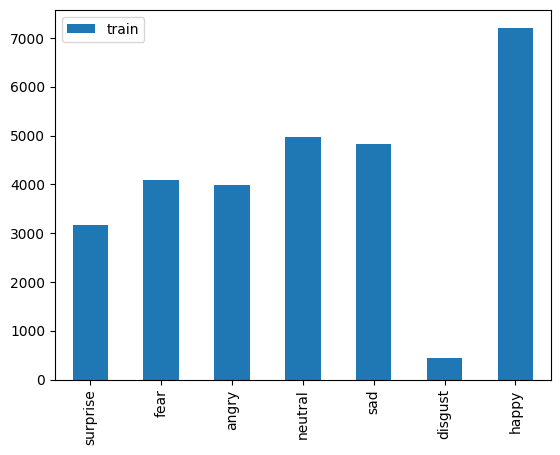

In [9]:
train_count.transpose().plot(kind='bar')

<Axes: >

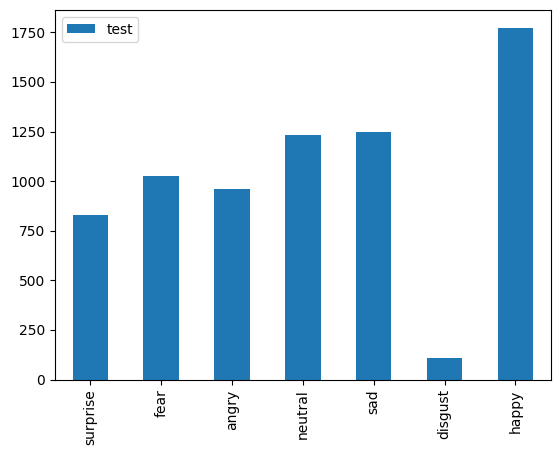

In [10]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion directory.

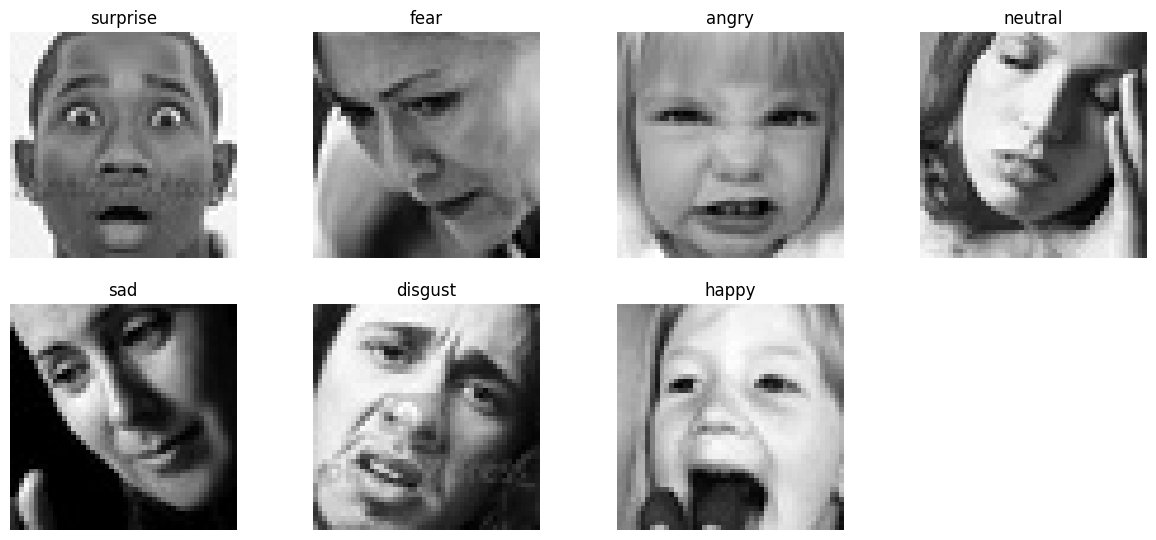

In [11]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[12])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.grid()
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## Plotting Some Random Images of Each Emotion

In [12]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

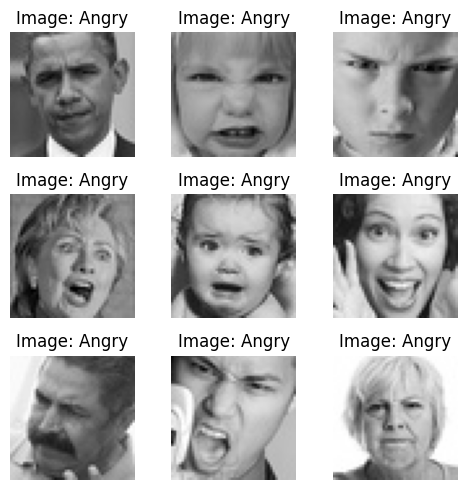

In [13]:
# Placeholder for the directory path
angry_directory_path = '/kaggle/input/fer2013/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

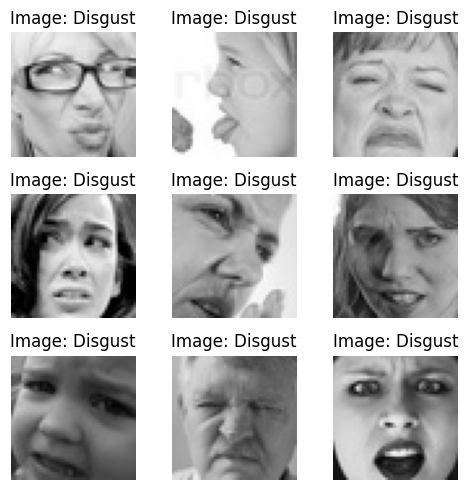

In [14]:
# Placeholder for the directory path
disgust_directory_path = '/kaggle/input/fer2013/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

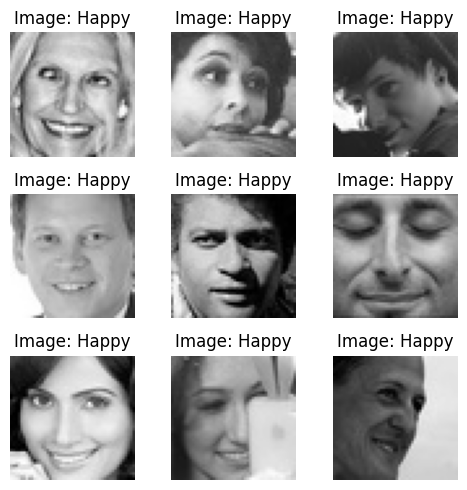

In [15]:
# Placeholder for the directory path
surpirse_directory_path = '/kaggle/input/fer2013/train/happy'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Happy')

# Checking shapes and channels of the Images.

In [16]:
import cv2

image_path = '/kaggle/input/fer2013/train/angry/Training_10120469.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [17]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/fer2013/train'
test_data_dir = '/kaggle/input/fer2013/test'

In [18]:
img_width, img_height = 48, 38
batch_size = 64
epochs = 10
num_classes = 7

In [19]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

In [20]:
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Classes**

In [21]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## **Building the CNN**

In [22]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 8, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 8, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 8, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 8, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 8, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    10,486,784 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,425,095 (55.03 MB)

 Trainable params: 14,423,431 (55.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Understanding Callbacks

In [25]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [26]:
# Aggregating all callbacks into a list
callbacks = [earlystop]  #  # Adjusted as per your use-case

In [27]:
train_generator.samples

22968

In [28]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# **Model Training**

In [29]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740991063.626313      92 service.cc:145] XLA service 0x78b968014dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740991063.626375      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1740991063.626381      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/359 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.1250 - loss: 16.1482   

I0000 00:00:1740991077.167862      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 164s 406ms/step - accuracy: 0.2316 - loss: 13.3459 - val_accuracy: 0.1188 - val_loss: 12.8389
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.3357 - loss: 10.7759 - val_accuracy: 0.3775 - val_loss: 9.4630
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.3855 - loss: 8.7714 - val_accuracy: 0.4292 - val_loss: 7.4564
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.4117 - loss: 6.9993 - val_accuracy: 0.4548 - val_loss: 5.8708
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.4521 - loss: 5.5342 - val_accuracy: 0.4562 - val_loss: 4.8259
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.4816 - loss: 4.4060 - val_accuracy: 0.4954 - val_loss: 3.8048
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.5072 - loss: 3.5645 - val_accuracy: 0.5123 - val_loss: 3.0807
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.5334 - loss: 2.9404 - val_ac

# **Plotting the Acvcuracy**

In [30]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

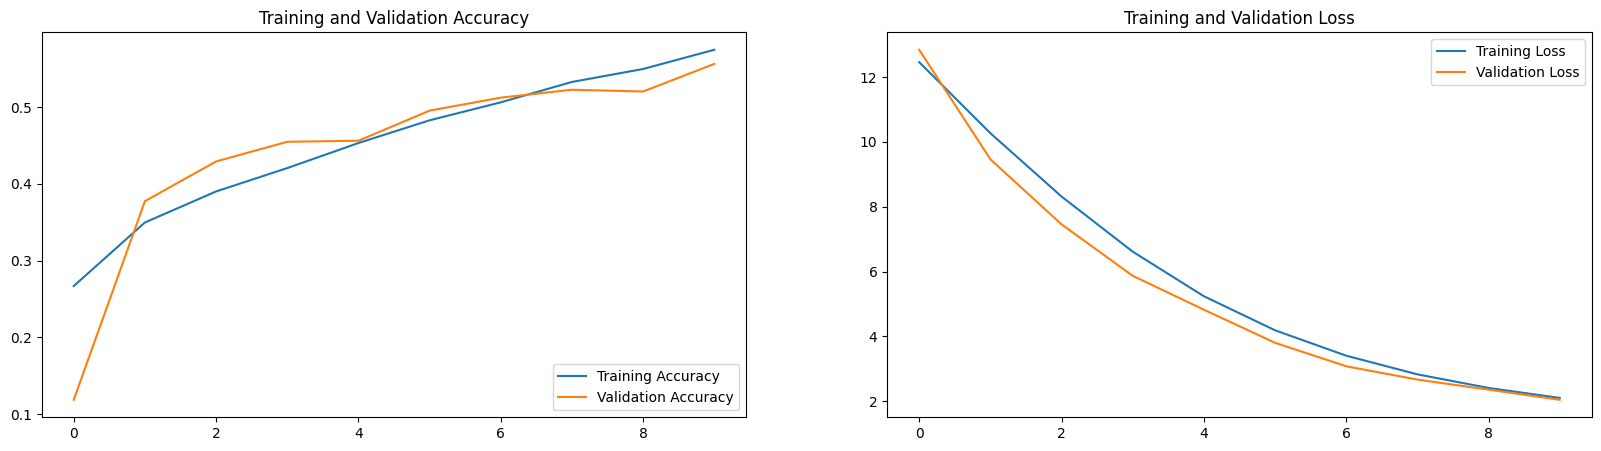

In [31]:
plot_training_history(history)

In [32]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.6276 - loss: 1.8595
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.5607 - loss: 2.0295
final train accuracy = 62.90 , validation accuracy = 56.56


In [33]:
import numpy as np

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step


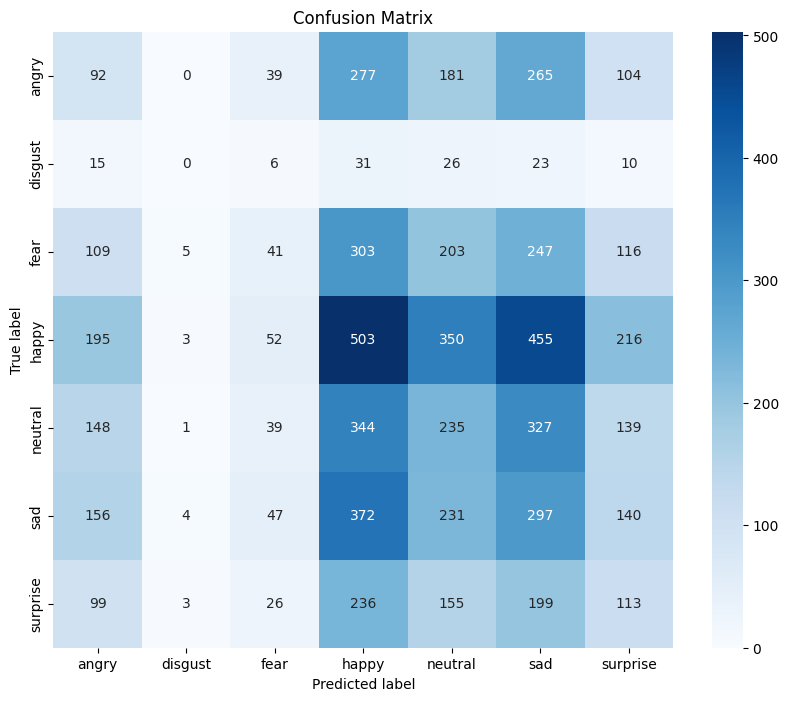

In [34]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [35]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.11      0.10      0.10       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.04      0.06      1024
       happy       0.24      0.28      0.26      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.16      0.24      0.19      1247
    surprise       0.13      0.14      0.14       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



# Making Predictions

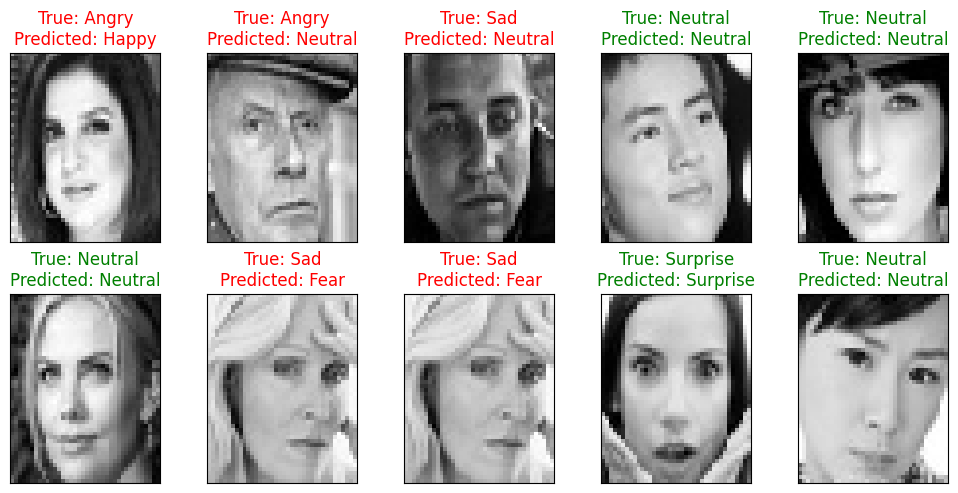

In [36]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Model 2: Image Augmentation**

In [37]:
# Define paths to the train and validation directories
train_data_dir = '/kaggle/input/fer2013/train'
test_data_dir = '/kaggle/input/fer2013/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Same CNN Model as above**

In [38]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)


# Aggregating all callbacks into a list
callbacks = [earlystop]  # Adjusted as per your use-case

In [41]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [42]:

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.2107 - loss: 13.3706 - val_accuracy: 0.1787 - val_loss: 12.0947
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.2373 - loss: 10.8542 - val_accuracy: 0.2317 - val_loss: 9.7249
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 88s 243ms/step - accuracy: 0.2393 - loss: 8.7138 - val_accuracy: 0.2372 - val_loss: 7.8684
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.2523 - loss: 6.8131 - val_accuracy: 0.2447 - val_loss: 5.7134
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.2577 - loss: 5.2980 - val_accuracy: 0.2454 - val_loss: 4.4400
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.2605 - loss: 4.1617 - val_accuracy: 0.2904 - val_loss: 3.5227
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.2754 - loss: 3.3558 - val_accuracy: 0.2726 - val_loss: 3.0385
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.2912 - loss: 2.8047 - val

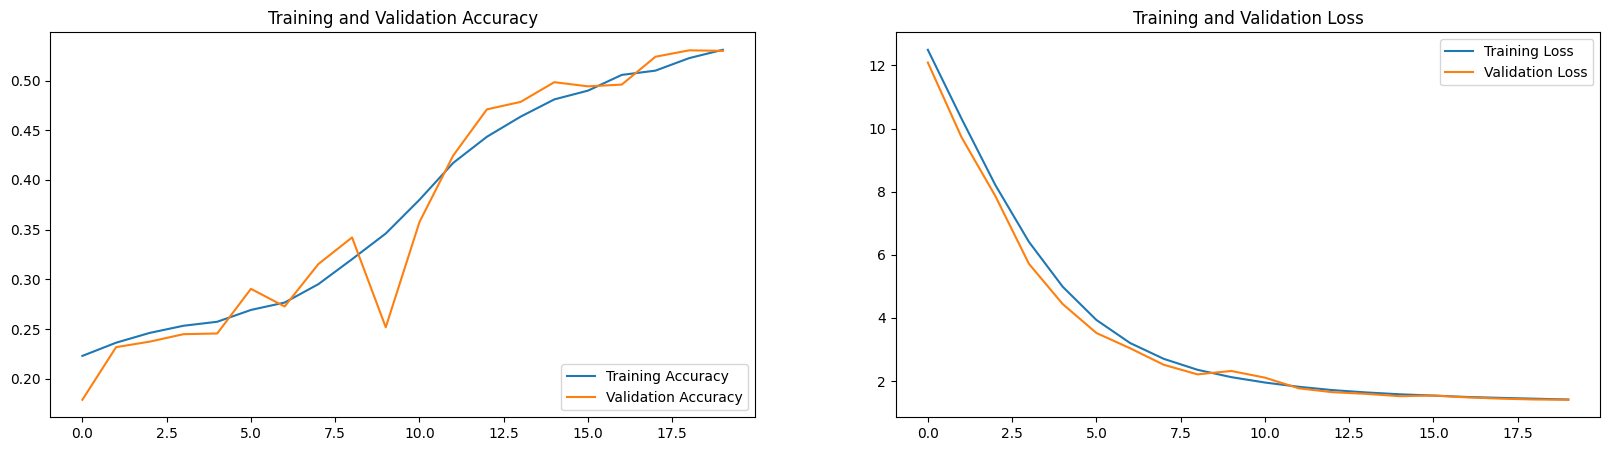

In [43]:
plot_training_history(history)

In [44]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.5383 - loss: 1.3872
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5486 - loss: 1.3387
final train accuracy = 54.24 , validation accuracy = 54.67


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


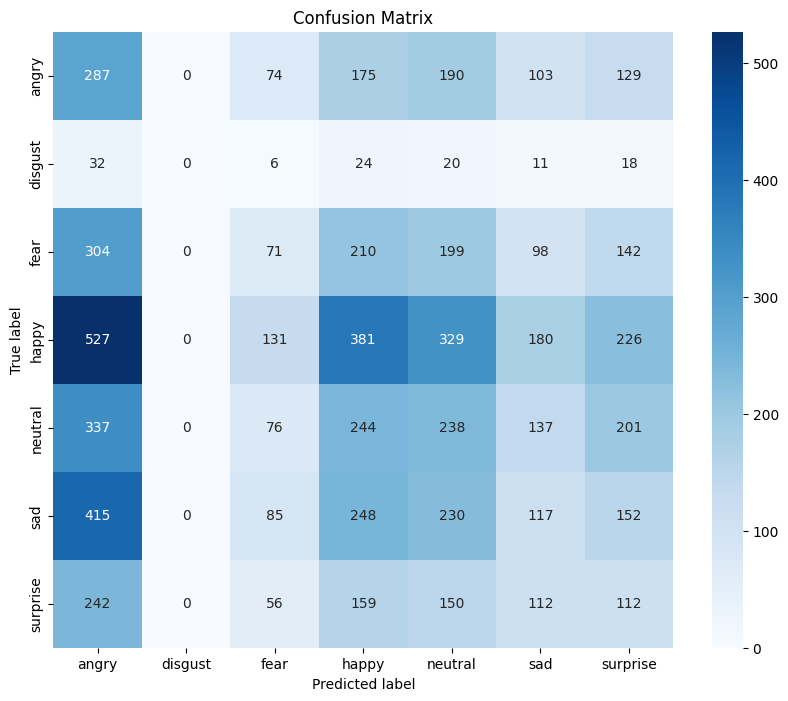

In [45]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [46]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.30      0.19       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.07      0.09      1024
       happy       0.26      0.21      0.24      1774
     neutral       0.18      0.19      0.18      1233
         sad       0.15      0.09      0.12      1247
    surprise       0.11      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178

